# Movie Recommendation System

This is the second part of my Springboard Capstone project on movie data analysis and recommendation system. In my first notebook (The Story of film), I attampted at narrating story of a film by performing extensive exporatory data analysis on movie metadata collected from IMDB. I also build 2 minimalistic predictive models to predict movie revenue and movie success and visualize which which features influence the output (succuess and revenue).

In this notebook, I will attempt at implementing a few recommendation algorithm (content based, popularity based and collaborative filtering) and try to build and ensemble of these models to come up with our final recommendation system

With us, we have two movie lense dataset:

#### Full dataset:

Cosists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1100 tags.

#### Small dataset:

Comprises of 100,000 ratings and 1300 tag applications applied to 9000 movies by 700 users.


I will make a simple recommender using movies from the full dataset whereas all personalized recommender systems will make use of small dataset due to computing power I posses being very limited. As a first step I will build my simple recommender system.

In [1]:
!pip install surprise

In [2]:
%matplotlib inline

import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [3]:
import warnings; warnings.simplefilter('ignore')

The simple recommender offers generalized recommendations to every user based on moie popularity and sometimes genre. The basic idea behind this recommender is that movie that are more popular and more crtically aclaimed will have higher probability of being liked by average audience. the model does not give personalized recommendation based on user.

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As added step, we can pass in agenre argument to get top movies of a genre.

In [4]:
md = pd.read_csv('C:\\Users\\bkumarsingh\\OneDrive - E2open, LLC\\Attachments\\AI\\Projects\\Kaggle\\Movie_Recommendation\\movies_metadata.csv')
md

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [5]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x:[i['name'] for i in x] if isinstance(x, list) else [])

In [6]:
md

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


I use TMDB rating to come up with our top movie chart. I will use IMDB weighted rating formula to construct my chart. Mathematically it is represented as follows:

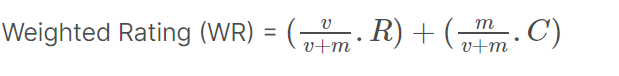


Where, 

v is number of votes for movie

m is minimum number of votes required to be listed in chart

R is the average rating of movie

C is mean vote across whole report

The next step is to determine appropriate value for m, the minimum votes required to be listed on chart. we will use 95th percentile as our cut off. in other words for a movie to feature in chart it must have more votes than atleast 95% of the movies in the list.

I will build our overall top 250 chart and will define a function to build chart for a particular genre. Let's begin!

In [7]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_counts

0        5415
1        2413
2          92
3          34
4         173
         ... 
45461       1
45462       3
45463       6
45464       0
45465       0
Name: vote_count, Length: 45460, dtype: int32

In [8]:
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
vote_averages

0        7
1        6
2        6
3        6
4        5
        ..
45461    4
45462    9
45463    3
45464    0
45465    0
Name: vote_average, Length: 45460, dtype: int32

In [9]:
C = vote_averages.mean()
C

5.244896612406511

In [10]:
m = vote_counts.quantile(0.95)
m 

434.0

95% of records have vote counts < 434

In [11]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x : str(x).split('-')[0] if x != np.nan else np.nan)
md[['release_date', 'year']]

,release_date,year
0,1995-10-30,1995
1,1995-12-15,1995
2,1995-12-22,1995
3,1995-12-22,1995
4,1995-02-10,1995
...,...,...
45461,NaN,NaT
45462,2011-11-17,2011
45463,2003-08-01,2003
45464,1917-10-21,1917


In [12]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified

,title,year,vote_count,vote_average,popularity,genres
0,Toy Story,1995,5415.0,7.7,21.946943,"[Animation, Comedy, Family]"
1,Jumanji,1995,2413.0,6.9,17.015539,"[Adventure, Fantasy, Family]"
5,Heat,1995,1886.0,7.7,17.924927,"[Action, Crime, Drama, Thriller]"
9,GoldenEye,1995,1194.0,6.6,14.686036,"[Adventure, Action, Thriller]"
15,Casino,1995,1343.0,7.8,10.137389,"[Drama, Crime]"
...,...,...,...,...,...,...
44624,What Happened to Monday,2017,598.0,7.3,60.581223,"[Science Fiction, Thriller]"
44632,Atomic Blonde,2017,748.0,6.1,14.455104,"[Action, Thriller]"
44678,Dunkirk,2017,2712.0,7.5,30.938854,"[Action, Drama, History, Thriller, War]"
44842,Transformers: The Last Knight,2017,1440.0,6.2,39.186819,"[Action, Science Fiction, Thriller, Adventure]"


In [13]:
qualified.vote_count = qualified.vote_count.astype('int')
qualified

,title,year,vote_count,vote_average,popularity,genres
0,Toy Story,1995,5415,7.7,21.946943,"[Animation, Comedy, Family]"
1,Jumanji,1995,2413,6.9,17.015539,"[Adventure, Fantasy, Family]"
5,Heat,1995,1886,7.7,17.924927,"[Action, Crime, Drama, Thriller]"
9,GoldenEye,1995,1194,6.6,14.686036,"[Adventure, Action, Thriller]"
15,Casino,1995,1343,7.8,10.137389,"[Drama, Crime]"
...,...,...,...,...,...,...
44624,What Happened to Monday,2017,598,7.3,60.581223,"[Science Fiction, Thriller]"
44632,Atomic Blonde,2017,748,6.1,14.455104,"[Action, Thriller]"
44678,Dunkirk,2017,2712,7.5,30.938854,"[Action, Drama, History, Thriller, War]"
44842,Transformers: The Last Knight,2017,1440,6.2,39.186819,"[Action, Science Fiction, Thriller, Adventure]"


In [14]:
qualified.vote_average = qualified.vote_average.astype('int')

In [15]:
qualified

,title,year,vote_count,vote_average,popularity,genres
0,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]"
1,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]"
5,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]"
9,GoldenEye,1995,1194,6,14.686036,"[Adventure, Action, Thriller]"
15,Casino,1995,1343,7,10.137389,"[Drama, Crime]"
...,...,...,...,...,...,...
44624,What Happened to Monday,2017,598,7,60.581223,"[Science Fiction, Thriller]"
44632,Atomic Blonde,2017,748,6,14.455104,"[Action, Thriller]"
44678,Dunkirk,2017,2712,7,30.938854,"[Action, Drama, History, Thriller, War]"
44842,Transformers: The Last Knight,2017,1440,6,39.186819,"[Action, Science Fiction, Thriller, Adventure]"


In [16]:
qualified.shape

(2274, 6)

Therefore, to qualify to be considered for the chart, a movie has to have at least 434 votes on TMDB. We also see that average rating for a movie on TMDB is 5.244 on a scale of 10. 2274 movies qualify to be on our chart.

In [17]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [18]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [19]:
qualified

,title,year,vote_count,vote_average,popularity,genres,wr
0,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]",6.869770
1,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]",5.884891
5,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]",6.671675
9,GoldenEye,1995,1194,6,14.686036,"[Adventure, Action, Thriller]",5.798701
15,Casino,1995,1343,7,10.137389,"[Drama, Crime]",6.571348
...,...,...,...,...,...,...,...
44624,What Happened to Monday,2017,598,7,60.581223,"[Science Fiction, Thriller]",6.261904
44632,Atomic Blonde,2017,748,6,14.455104,"[Action, Thriller]",5.722745
44678,Dunkirk,2017,2712,7,30.938854,"[Action, Drama, History, Thriller, War]",6.757878
44842,Transformers: The Last Knight,2017,1440,6,39.186819,"[Action, Science Fiction, Thriller, Adventure]",5.825125


In [20]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [21]:
qualified

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
...,...,...,...,...,...,...,...
2006,Indiana Jones and the Temple of Doom,1984,2841,7,15.802306,"[Adventure, Action]",6.767415
16129,The King's Speech,2010,2817,7,11.260387,"[Drama, History]",6.765698
895,Sunset Boulevard,1950,533,8,11.709777,[Drama],6.763480
9888,Sin City,2005,2755,7,15.010525,"[Action, Thriller, Crime]",6.761143


We see that three Christopher Nolan Films, Inception, The Dark Night and Intersteller occur at very top of our chart. The chart also indicates  a strong bias of TMDB users towards particular genres and directores.

Let now construct our function that builds chart for particular genres. For this we will use relax our default conditions to the 85th percentile instead of 95.

In [22]:
s = md.apply(lambda x : pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)

In [23]:
s

0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45461       Family
45462        Drama
45463       Action
45463        Drama
45463     Thriller
Length: 91106, dtype: object

In [24]:
s.name = 'genre'
s

0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45461       Family
45462        Drama
45463       Action
45463        Drama
45463     Thriller
Name: genre, Length: 91106, dtype: object

In [25]:
gen_md = md.drop('genres', axis=1).join(s)
gen_md

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45463,False,NaN,0,NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,Action
45463,False,NaN,0,NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,Drama
45463,False,NaN,0,NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,Thriller
45464,False,NaN,0,NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,...,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917,NaN


In [26]:
def build_chart(genre, percentile=0.85):
    
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified.vote_count = qualified.vote_count.astype('int')
    qualified.vote_average = qualified.vote_average.astype('int')
    
    qualified['wr'] = qualified.apply(lambda x : (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

Let us see our method in action by displaying top 15 Romance movies (Romance genre didn't appear at all in our Generic Top Chart despite being one of the most popular movie genre).

### Top Romance Movies

In [27]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


The top romance movie according to our metrics in Bollywood's Dilwale Dulhania Le Jayenge. This Shahrukh Khan starrer also happens to be my personal favorites.

# Content based recommender

The recommender we built in previous section suffers more sevre limitation. For one, it gives same recommendation to everyone, regardless of user personal taste. If a person who loves romantic movies (and hates action) were to look at our top 15 chart, s/he wouldnt probably like most of the movies. if s/he were to go one step further and look at our chart by genre, she wouldn't still be getting the best recommendation. 

For example, consider a person who loves Dilwale Dulhania Le Jayenge, My name is khan, Kabhi Khushi Kabhi Gham. One inference we can obtain is that person loves the actor Shah Rukh Khan and Director Karan Jauhar. Even s/he were to access romance chart, s/he wouldn't find these as top recommendation. 

To personalize our recommendation more, I am going to build an engine that computes similarity between movies based on certain metrics, and suggest movies that are similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as content based filtering.

I will build two content based recommender based on:

1. Movie overview and taglines
2. Movie Cast, Crew, Keywords and Genre

Also, as mentioned in introduction I will be using a subset of movies dataset available to us due to limited comuting power I have.



In [28]:
links_small = pd.read_csv('C:\\Users\\bkumarsingh\\OneDrive - E2open, LLC\\Attachments\\AI\\Projects\\Kaggle\\Movie_Recommendation\\links_small.csv')
links_small

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9120,162672,3859980,402672.0
9121,163056,4262980,315011.0
9122,163949,2531318,391698.0
9123,164977,27660,137608.0


In [29]:
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [30]:
links_small

0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9120    402672
9121    315011
9122    391698
9123    137608
9124    410803
Name: tmdbId, Length: 9112, dtype: int32

In [31]:
md = md.drop([19730, 29503, 35587])
md

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaT
45462,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2011
45463,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917


In [32]:
# Check EDA notebook how any why I got these indices

md['id'] = md['id'].astype('int')
md

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaT
45462,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2011
45463,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917


In [33]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

We have 9099 movies available in our small movies metadata dataset which is 5 times smaller than our oiriginal dataset of 45000 movies. 

## Movie description based recommender

Let us first try to build a recommender using movie description and taglines. We do not have a quantitative metric to judge our machine performance so this will have to be done qualitatively.



In [34]:
print(smd['tagline'].isnull().sum())
smd['tagline'] = smd['tagline'].fillna('')
print(smd['tagline'].isnull().sum())
smd['description'] = smd['overview'] + smd['tagline']
print(smd['description'].isnull().sum())


2066
0
12


In [35]:
smd['description'] = smd['description'].fillna('')
print(smd['description'].isnull().sum())

0


In [36]:
print(smd['overview'].isnull().sum())

12


In [37]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd.description)
tfidf_matrix

<9099x268124 sparse matrix of type '<class 'numpy.float64'>'
	with 540591 stored elements in Compressed Sparse Row format>

In [38]:
tfidf_matrix.shape

(9099, 268124)

### Cosine Similarity

I will be using Cosine Similarity to calculate a numeric quantity that denotes similarity between two movies.

Mathematically it's defined as follows,

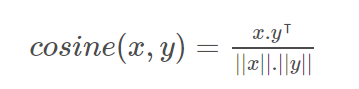

Since, we have used TFIDF Vectorizer, calculate the dot product will directly give us cosine similarity score. 

Therefore, we will use sklearn liniear kernel instead of cosine similarty since it's much master.



In [39]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

We now have pairwise cosine similarity for all movies in our dataset. The next step is to write a function returns 30 most similar movies based on cosine similarity score.

In [40]:
smd

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,A family wedding reignites the ancient feud be...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,Just when George Banks has recovered from his ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40224,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,120.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,A god incarnate. A city doomed.,Shin Godzilla,False,6.6,152.0,2016,From the mind behind Evangelion comes a hit la...
40503,False,NaN,0,"[Documentary, Music]",http://www.thebeatlesliveproject.com/,391698,tt2531318,en,The Beatles: Eight Days a Week - The Touring Y...,"The band stormed Europe in 1963, and, in 1964,...",...,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The band you know. The story you don't.,The Beatles: Eight Days a Week - The Touring Y...,False,7.6,92.0,2016,"The band stormed Europe in 1963, and, in 1964,..."
44821,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",16000000,"[Adventure, Fantasy, Animation, Action, Family]",http://movies.warnerbros.com/pk3/,10991,tt0235679,ja,Pokémon 3: The Movie,When Molly Hale's sadness of her father's disa...,...,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pokémon: Spell of the Unknown,Pokémon: Spell of the Unknown,False,6.0,144.0,2000,When Molly Hale's sadness of her father's disa...
44826,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",0,"[Adventure, Fantasy, Animation, Science Fictio...",http://www.pokemon.com/us/movies/movie-pokemon...,12600,tt0287635,ja,劇場版ポケットモンスター セレビィ 時を越えた遭遇（であい）,"All your favorite Pokémon characters are back,...",...,75.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,,Pokémon 4Ever: Celebi - Voice of the Forest,False,5.7,82.0,2001,"All your favorite Pokémon characters are back,..."


In [41]:
smd = smd.reset_index()

In [42]:
smd

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,description
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ..."
1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,A family wedding reignites the ancient feud be...
3,3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom..."
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,Just when George Banks has recovered from his ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9094,40224,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,...,120.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,A god incarnate. A city doomed.,Shin Godzilla,False,6.6,152.0,2016,From the mind behind Evangelion comes a hit la...
9095,40503,False,NaN,0,"[Documentary, Music]",http://www.thebeatlesliveproject.com/,391698,tt2531318,en,The Beatles: Eight Days a Week - The Touring Y...,...,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The band you know. The story you don't.,The Beatles: Eight Days a Week - The Touring Y...,False,7.6,92.0,2016,"The band stormed Europe in 1963, and, in 1964,..."
9096,44821,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",16000000,"[Adventure, Fantasy, Animation, Action, Family]",http://movies.warnerbros.com/pk3/,10991,tt0235679,ja,Pokémon 3: The Movie,...,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pokémon: Spell of the Unknown,Pokémon: Spell of the Unknown,False,6.0,144.0,2000,When Molly Hale's sadness of her father's disa...
9097,44826,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",0,"[Adventure, Fantasy, Animation, Science Fictio...",http://www.pokemon.com/us/movies/movie-pokemon...,12600,tt0287635,ja,劇場版ポケットモンスター セレビィ 時を越えた遭遇（であい）,...,75.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,,Pokémon 4Ever: Celebi - Voice of the Forest,False,5.7,82.0,2001,"All your favorite Pokémon characters are back,..."


In [43]:
titles = smd.title
titles

0                                               Toy Story
1                                                 Jumanji
2                                        Grumpier Old Men
3                                       Waiting to Exhale
4                             Father of the Bride Part II
                              ...                        
9094                                        Shin Godzilla
9095    The Beatles: Eight Days a Week - The Touring Y...
9096                        Pokémon: Spell of the Unknown
9097          Pokémon 4Ever: Celebi - Voice of the Forest
9098                                        Force Majeure
Name: title, Length: 9099, dtype: object

In [44]:
indices = pd.Series(smd.index, index=smd['title'])
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
Shin Godzilla                                         9094
The Beatles: Eight Days a Week - The Touring Years    9095
Pokémon: Spell of the Unknown                         9096
Pokémon 4Ever: Celebi - Voice of the Forest           9097
Force Majeure                                         9098
Length: 9099, dtype: int64

In [45]:
def get_recommendation(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    print(sim_scores[1:31])
    sim_scores = sorted(sim_scores, key=lambda x : x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

We're all set. Let us now try and get the top recommendations for a few movies and see how good recommendations are. 

In [46]:
get_recommendation('The Godfather').head(10)

[(1, 0.00282712634654008), (2, 0.013274406850346377), (3, 0.0), (4, 0.001911923808690747), (5, 0.009831202255696751), (6, 0.0), (7, 0.0048937541840076175), (8, 0.0), (9, 0.007200486377613863), (10, 0.0), (11, 0.0), (12, 0.002629662427098924), (13, 0.01655348503181121), (14, 0.0), (15, 0.003311321356213731), (16, 0.0), (17, 0.0017852909522175192), (18, 0.0), (19, 0.0), (20, 0.00138960229604634), (21, 0.02347433335488712), (22, 0.002909885967091068), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.011643868586706513), (28, 0.0), (29, 0.056141832299658065), (30, 0.0)]


973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [47]:
get_recommendation('The Dark Knight').head(10)

[(1, 0.007774131635450035), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.004610245611341961), (6, 0.0), (7, 0.0), (8, 0.003941701813242567), (9, 0.0), (10, 0.0), (11, 0.015033901723582844), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.003060523962865731), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.00554416072159223), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.005685807213192394), (30, 0.0)]


7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

We see that for dark knight our system is able to dentify it as batman movie and subsequently recommend other batman film as its top recommendation. But unfortunately, that is all this system can do at this moment. This is not of much use to most people as it doesn't take into consideration very important features such as cast crew and directors and genre which determine the rating and popularity of a movie. Someone who liked the dark knight probably likes it because of Nolan and would hate batman forever and every other substandard movie in batman franchise. 

Therefore, we are going to use much more suggestive metadata than overview and tagline. In the next subsection we will build a more sophisticated recommender that takes genre, keywords, cast and crew into consideration. 


### Metadata Based Recommender

To build our standard metadata based recommender, we will need to merge our current dataset with keyword and crew dataset. Let us prepare this data as our first step.

In [48]:
credits = pd.read_csv('C:\\Users\\bkumarsingh\\OneDrive - E2open, LLC\\Attachments\\AI\\Projects\\Kaggle\\Movie_Recommendation\\credits.csv')
credits

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506


In [49]:
keywords = pd.read_csv('C:\\Users\\bkumarsingh\\OneDrive - E2open, LLC\\Attachments\\AI\\Projects\\Kaggle\\Movie_Recommendation\\keywords.csv')
keywords

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [50]:
print(keywords.info())
keywords.id = keywords.id.astype('int')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB
None


In [51]:
print(keywords.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int32 
 1   keywords  46419 non-null  object
dtypes: int32(1), object(1)
memory usage: 544.1+ KB
None


In [52]:
credits.id = credits.id.astype('int')

In [53]:
md.id = md.id.astype('int')

In [54]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')
md

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46623,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaT,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...","[{'id': 10703, 'name': 'tragic love'}]"
46624,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,Released,NaN,Century of Birthing,False,9.0,3.0,2011,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...","[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46625,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",[]
46626,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,Released,NaN,Satan Triumphant,False,0.0,0.0,1917,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",[]


In [55]:
smd = md[md.id.isin(links_small)]

In [56]:
smd.shape

(9219, 28)

We now have our cast, crew, genres and credits all in one dataframe. Let us wrangle this a little more using the following intutions:

### 1. Crew

From the crew, we will only pick the director as out feature since other don't contribute that much to the feel of movie. 

### 2. Cast

Choosing cast is little more tricky, Lesser known actors and minor roles do not really affects people opinion about movie. Therefore we must select major charecters and their respective actors. Arbitarily we will choose the top 3 actors that appear in credit list.  

In [57]:
smd.cast = smd.cast.apply(literal_eval)
smd.crew = smd.crew.apply(literal_eval)
smd.keywords = smd.keywords.apply(literal_eval)
smd['cast_size'] = smd.cast.apply(lambda x : len(x))
smd['crew_size'] = smd.crew.apply(lambda x : len(x))

In [58]:
smd

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,title,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40952,False,NaN,8000000,[Drama],NaN,159550,tt0255313,en,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,...,The Last Brickmaker in America,False,7.0,1.0,2001,"[{'cast_id': 1, 'character': 'Henry Cobb', 'cr...","[{'credit_id': '544475aac3a36819fb000578', 'de...","[{'id': 6054, 'name': 'friendship'}, {'id': 20...",7,2
41172,False,NaN,1000000,"[Thriller, Romance]",NaN,392572,tt5165344,hi,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...",...,Rustom,False,7.3,25.0,2016,"[{'cast_id': 0, 'character': 'Rustom Pavri', '...","[{'credit_id': '5951baf692514129c4016600', 'de...","[{'id': 10540, 'name': 'bollywood'}]",14,16
41225,False,NaN,15050000,"[Adventure, Drama, History, Romance]",NaN,402672,tt3859980,hi,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...",...,Mohenjo Daro,False,6.7,26.0,2016,"[{'cast_id': 0, 'character': 'Sarman', 'credit...","[{'credit_id': '57cd5d3592514179d50018e8', 'de...","[{'id': 10540, 'name': 'bollywood'}]",12,16
41391,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,Shin Godzilla,False,6.6,152.0,2016,"[{'cast_id': 4, 'character': 'Rando Yaguchi : ...","[{'credit_id': '560892fa92514177550018b2', 'de...","[{'id': 1299, 'name': 'monster'}, {'id': 7671,...",49,27


In [59]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


In [60]:
smd['director'] = smd['crew'].apply(get_director)
smd[['director', 'crew']]

,director,crew
0,John Lasseter,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,Joe Johnston,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,Howard Deutch,"[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,Forest Whitaker,"[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,Charles Shyer,"[{'credit_id': '52fe44959251416c75039ed7', 'de..."
...,...,...
40952,Gregg Champion,"[{'credit_id': '544475aac3a36819fb000578', 'de..."
41172,Tinu Suresh Desai,"[{'credit_id': '5951baf692514129c4016600', 'de..."
41225,Ashutosh Gowariker,"[{'credit_id': '57cd5d3592514179d50018e8', 'de..."
41391,Hideaki Anno,"[{'credit_id': '560892fa92514177550018b2', 'de..."


In [61]:
smd['cast'] = smd['cast'].apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])


In [62]:
smd['cast']

0        [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...
1        [Robin Williams, Jonathan Hyde, Kirsten Dunst,...
2        [Walter Matthau, Jack Lemmon, Ann-Margret, Sop...
3        [Whitney Houston, Angela Bassett, Loretta Devi...
4        [Steve Martin, Diane Keaton, Martin Short, Kim...
                               ...                        
40952    [Sidney Poitier, Wendy Crewson, Jay O. Sanders...
41172    [Akshay Kumar, Ileana D'Cruz, Esha Gupta, Arja...
41225    [Hrithik Roshan, Pooja Hegde, Kabir Bedi, Arun...
41391    [Hiroki Hasegawa, Yutaka Takenouchi, Satomi Is...
41669    [Paul McCartney, Ringo Starr, John Lennon, Geo...
Name: cast, Length: 9219, dtype: object

In [63]:
smd['cast'] = smd['cast'].apply(lambda x : x[:3] if len(x) >= 3 else x)
smd['keywords'] = smd['keywords'].apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])

In [64]:
smd['cast']

0                      [Tom Hanks, Tim Allen, Don Rickles]
1           [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2               [Walter Matthau, Jack Lemmon, Ann-Margret]
3        [Whitney Houston, Angela Bassett, Loretta Devine]
4               [Steve Martin, Diane Keaton, Martin Short]
                               ...                        
40952      [Sidney Poitier, Wendy Crewson, Jay O. Sanders]
41172            [Akshay Kumar, Ileana D'Cruz, Esha Gupta]
41225            [Hrithik Roshan, Pooja Hegde, Kabir Bedi]
41391    [Hiroki Hasegawa, Yutaka Takenouchi, Satomi Is...
41669           [Paul McCartney, Ringo Starr, John Lennon]
Name: cast, Length: 9219, dtype: object

My approach to building the recommender is going to be extremely hacky. What I plsan doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. I then use a count vectorizer to create or count matrix as we did in description recommender. The remaining steps are similar to what we did earlier: we calculate cosine similarity and return that are most similar.

These are the steps I follow in preperation of my genres and credits data:

#### 1. Strip spaces and convert to lowercase:

from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.

#### 2. Mention Director 3 times to give it more weight relative to entire cast

In [65]:
print(smd['cast'])
smd.cast = smd.cast.apply(lambda x : [str.lower(i.replace(" ", "")) for i in x])
print(smd['cast'])

0                      [Tom Hanks, Tim Allen, Don Rickles]
1           [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2               [Walter Matthau, Jack Lemmon, Ann-Margret]
3        [Whitney Houston, Angela Bassett, Loretta Devine]
4               [Steve Martin, Diane Keaton, Martin Short]
                               ...                        
40952      [Sidney Poitier, Wendy Crewson, Jay O. Sanders]
41172            [Akshay Kumar, Ileana D'Cruz, Esha Gupta]
41225            [Hrithik Roshan, Pooja Hegde, Kabir Bedi]
41391    [Hiroki Hasegawa, Yutaka Takenouchi, Satomi Is...
41669           [Paul McCartney, Ringo Starr, John Lennon]
Name: cast, Length: 9219, dtype: object
0                         [tomhanks, timallen, donrickles]
1              [robinwilliams, jonathanhyde, kirstendunst]
2                 [waltermatthau, jacklemmon, ann-margret]
3           [whitneyhouston, angelabassett, lorettadevine]
4                  [stevemartin, dianekeaton, martinshort]
                

In [66]:
print(smd.director)
smd.director = smd.director.astype('str').apply(lambda x : str.lower(x.replace(" ", "")))
print(smd.director)

0             John Lasseter
1              Joe Johnston
2             Howard Deutch
3           Forest Whitaker
4             Charles Shyer
                ...        
40952        Gregg Champion
41172     Tinu Suresh Desai
41225    Ashutosh Gowariker
41391          Hideaki Anno
41669            Ron Howard
Name: director, Length: 9219, dtype: object
0             johnlasseter
1              joejohnston
2             howarddeutch
3           forestwhitaker
4             charlesshyer
               ...        
40952        greggchampion
41172      tinusureshdesai
41225    ashutoshgowariker
41391          hideakianno
41669            ronhoward
Name: director, Length: 9219, dtype: object


In [67]:
smd.director = smd.director.apply(lambda x : [x, x, x])
print(smd.director)

0               [johnlasseter, johnlasseter, johnlasseter]
1                  [joejohnston, joejohnston, joejohnston]
2               [howarddeutch, howarddeutch, howarddeutch]
3         [forestwhitaker, forestwhitaker, forestwhitaker]
4               [charlesshyer, charlesshyer, charlesshyer]
                               ...                        
40952        [greggchampion, greggchampion, greggchampion]
41172    [tinusureshdesai, tinusureshdesai, tinusureshd...
41225    [ashutoshgowariker, ashutoshgowariker, ashutos...
41391              [hideakianno, hideakianno, hideakianno]
41669                    [ronhoward, ronhoward, ronhoward]
Name: director, Length: 9219, dtype: object


#### Keywords:

We will do small amount of preprocessing of our keywords before before putting them to any use. As a first step, we will calculate fequency counts of every keywords that appears in dataset.

In [68]:
s = smd.apply(lambda x : pd.Series(x['keywords']), axis=1).stack().reset_index(level=1, drop=True)
s.name ='keyword'
s

0           jealousy
0                toy
0                boy
0         friendship
0            friends
            ...     
41391    destruction
41391          kaiju
41391          toyko
41669          music
41669    documentary
Name: keyword, Length: 64407, dtype: object

In [69]:
smd['keywords']

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, based on children'...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
40952                           [friendship, brick making]
41172                                          [bollywood]
41225                                          [bollywood]
41391    [monster, godzilla, giant monster, destruction...
41669                                 [music, documentary]
Name: keywords, Length: 9219, dtype: object

In [70]:
s = s.value_counts()
s.min(), s.max()

(1, 610)

Keywords occur in frequencies ranging from 1 to 610. We do not have use of keywords that occur only once. Therefore these can be safely removed. Finally, we will convert every word to stem, so that words such as Dogs and Dog are considered same. 

In [71]:
s = s[s>1]
s

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
                       ... 
boarder                   2
pantyhose                 2
eggs                      2
giant  squid              2
hair                      2
Name: keyword, Length: 6709, dtype: int64

In [72]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [73]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [74]:
smd.keywords = smd.keywords.apply(filter_keywords)
smd.keywords

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, based on children'...
2             [fishing, best friend, duringcreditsstinger]
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
40952                                         [friendship]
41172                                          [bollywood]
41225                                          [bollywood]
41391    [monster, godzilla, giant monster, destruction...
41669                                 [music, documentary]
Name: keywords, Length: 9219, dtype: object

In [75]:
smd.keywords = smd.keywords.apply(lambda x : [stemmer.stem(i) for i in x])
smd.keywords = smd.keywords.apply(lambda x : [str.lower(i.replace(" ", "")) for i in x])
smd.keywords

0        [jealousi, toy, boy, friendship, friend, rival...
1        [boardgam, disappear, basedonchildren'sbook, n...
2                   [fish, bestfriend, duringcreditssting]
3        [basedonnovel, interracialrelationship, single...
4        [babi, midlifecrisi, confid, age, daughter, mo...
                               ...                        
40952                                         [friendship]
41172                                          [bollywood]
41225                                          [bollywood]
41391     [monster, godzilla, giantmonst, destruct, kaiju]
41669                                 [music, documentari]
Name: keywords, Length: 9219, dtype: object

In [76]:
smd['soup'] = smd.keywords + smd.cast + smd.director + smd.genres
smd['soup']

0        [jealousi, toy, boy, friendship, friend, rival...
1        [boardgam, disappear, basedonchildren'sbook, n...
2        [fish, bestfriend, duringcreditssting, walterm...
3        [basedonnovel, interracialrelationship, single...
4        [babi, midlifecrisi, confid, age, daughter, mo...
                               ...                        
40952    [friendship, sidneypoitier, wendycrewson, jayo...
41172    [bollywood, akshaykumar, ileanad'cruz, eshagup...
41225    [bollywood, hrithikroshan, poojahegde, kabirbe...
41391    [monster, godzilla, giantmonst, destruct, kaij...
41669    [music, documentari, paulmccartney, ringostarr...
Name: soup, Length: 9219, dtype: object

In [77]:
smd.soup = smd.soup.apply(lambda x : ' '.join(x))
smd.soup

0        jealousi toy boy friendship friend rivalri boy...
1        boardgam disappear basedonchildren'sbook newho...
2        fish bestfriend duringcreditssting waltermatth...
3        basedonnovel interracialrelationship singlemot...
4        babi midlifecrisi confid age daughter motherda...
                               ...                        
40952    friendship sidneypoitier wendycrewson jayo.san...
41172    bollywood akshaykumar ileanad'cruz eshagupta t...
41225    bollywood hrithikroshan poojahegde kabirbedi a...
41391    monster godzilla giantmonst destruct kaiju hir...
41669    music documentari paulmccartney ringostarr joh...
Name: soup, Length: 9219, dtype: object

In [78]:
count = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [79]:
count_matrix

<9219x107377 sparse matrix of type '<class 'numpy.int64'>'
	with 240050 stored elements in Compressed Sparse Row format>

In [80]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.02441931, 0.02738955, ..., 0.        , 0.        ,
        0.        ],
       [0.02441931, 1.        , 0.        , ..., 0.02973505, 0.02500782,
        0.        ],
       [0.02738955, 0.        , 1.        , ..., 0.03335187, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02973505, 0.03335187, ..., 1.        , 0.08700222,
        0.        ],
       [0.        , 0.02500782, 0.        , ..., 0.08700222, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [81]:
smd

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director,soup
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,"[johnlasseter, johnlasseter, johnlasseter]",jealousi toy boy friendship friend rivalri boy...
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,"[joejohnston, joejohnston, joejohnston]",boardgam disappear basedonchildren'sbook newho...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]",7,4,"[howarddeutch, howarddeutch, howarddeutch]",fish bestfriend duringcreditssting waltermatth...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]",basedonnovel interracialrelationship singlemot...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,"[charlesshyer, charlesshyer, charlesshyer]",babi midlifecrisi confid age daughter motherda...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40952,False,NaN,8000000,[Drama],NaN,159550,tt0255313,en,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,...,7.0,1.0,2001,"[sidneypoitier, wendycrewson, jayo.sanders]","[{'credit_id': '544475aac3a36819fb000578', 'de...",[friendship],7,2,"[greggchampion, greggchampion, greggchampion]",friendship sidneypoitier wendycrewson jayo.san...
41172,False,NaN,1000000,"[Thriller, Romance]",NaN,392572,tt5165344,hi,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...",...,7.3,25.0,2016,"[akshaykumar, ileanad'cruz, eshagupta]","[{'credit_id': '5951baf692514129c4016600', 'de...",[bollywood],14,16,"[tinusureshdesai, tinusureshdesai, tinusureshd...",bollywood akshaykumar ileanad'cruz eshagupta t...
41225,False,NaN,15050000,"[Adventure, Drama, History, Romance]",NaN,402672,tt3859980,hi,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...",...,6.7,26.0,2016,"[hrithikroshan, poojahegde, kabirbedi]","[{'credit_id': '57cd5d3592514179d50018e8', 'de...",[bollywood],12,16,"[ashutoshgowariker, ashutoshgowariker, ashutos...",bollywood hrithikroshan poojahegde kabirbedi a...
41391,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,6.6,152.0,2016,"[hirokihasegawa, yutakatakenouchi, satomiishih...","[{'credit_id': '560892fa92514177550018b2', 'de...","[monster, godzilla, giantmonst, destruct, kaiju]",49,27,"[hideakianno, hideakianno, hideakianno]",monster godzilla giantmonst destruct kaiju hir...


In [82]:
smd = smd.reset_index()

In [83]:
smd

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director,soup
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,"[johnlasseter, johnlasseter, johnlasseter]",jealousi toy boy friendship friend rivalri boy...
1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,...,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,"[joejohnston, joejohnston, joejohnston]",boardgam disappear basedonchildren'sbook newho...
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,...,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]",7,4,"[howarddeutch, howarddeutch, howarddeutch]",fish bestfriend duringcreditssting waltermatth...
3,3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,...,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]",basedonnovel interracialrelationship singlemot...
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,...,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,"[charlesshyer, charlesshyer, charlesshyer]",babi midlifecrisi confid age daughter motherda...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,40952,False,NaN,8000000,[Drama],NaN,159550,tt0255313,en,The Last Brickmaker in America,...,7.0,1.0,2001,"[sidneypoitier, wendycrewson, jayo.sanders]","[{'credit_id': '544475aac3a36819fb000578', 'de...",[friendship],7,2,"[greggchampion, greggchampion, greggchampion]",friendship sidneypoitier wendycrewson jayo.san...
9215,41172,False,NaN,1000000,"[Thriller, Romance]",NaN,392572,tt5165344,hi,रुस्तम,...,7.3,25.0,2016,"[akshaykumar, ileanad'cruz, eshagupta]","[{'credit_id': '5951baf692514129c4016600', 'de...",[bollywood],14,16,"[tinusureshdesai, tinusureshdesai, tinusureshd...",bollywood akshaykumar ileanad'cruz eshagupta t...
9216,41225,False,NaN,15050000,"[Adventure, Drama, History, Romance]",NaN,402672,tt3859980,hi,Mohenjo Daro,...,6.7,26.0,2016,"[hrithikroshan, poojahegde, kabirbedi]","[{'credit_id': '57cd5d3592514179d50018e8', 'de...",[bollywood],12,16,"[ashutoshgowariker, ashutoshgowariker, ashutos...",bollywood hrithikroshan poojahegde kabirbedi a...
9217,41391,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,...,6.6,152.0,2016,"[hirokihasegawa, yutakatakenouchi, satomiishih...","[{'credit_id': '560892fa92514177550018b2', 'de...","[monster, godzilla, giantmonst, destruct, kaiju]",49,27,"[hideakianno, hideakianno, hideakianno]",monster godzilla giantmonst destruct kaiju hir...


In [85]:
titles = smd.title
titles

0                                               Toy Story
1                                                 Jumanji
2                                        Grumpier Old Men
3                                       Waiting to Exhale
4                             Father of the Bride Part II
                              ...                        
9214                       The Last Brickmaker in America
9215                                               Rustom
9216                                         Mohenjo Daro
9217                                        Shin Godzilla
9218    The Beatles: Eight Days a Week - The Touring Y...
Name: title, Length: 9219, dtype: object

In [86]:
indices = pd.Series(smd.index, index=smd.title)
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
The Last Brickmaker in America                        9214
Rustom                                                9215
Mohenjo Daro                                          9216
Shin Godzilla                                         9217
The Beatles: Eight Days a Week - The Touring Years    9218
Length: 9219, dtype: int64

We will reuse the get_recommendation fuction we created earlier. Since our cosine similarity score hve been changed, we expect it to give different (probably better) results. Let us see for The Dark Knight again and see what recommendation I get this time around. 

In [87]:
get_recommendation('The Dark Knight')

[(1, 0.0), (2, 0.0), (3, 0.020965696734438367), (4, 0.0), (5, 0.08481041912882635), (6, 0.0), (7, 0.04774099160262887), (8, 0.04193139346887673), (9, 0.05017452060042545), (10, 0.020965696734438367), (11, 0.0), (12, 0.0), (13, 0.020965696734438367), (14, 0.020965696734438367), (15, 0.04318335170875306), (16, 0.01891511969643836), (17, 0.018490006540840973), (18, 0.02159167585437653), (19, 0.04193139346887673), (20, 0.047643061260321314), (21, 0.04078236951430929), (22, 0.06153846153846155), (23, 0.035438495596916704), (24, 0.016428801936338142), (25, 0.023870495801314433), (26, 0.020391184757154644), (27, 0.02303267198524394), (28, 0.0), (29, 0.039722906114947866), (30, 0.033449680400283635)]


8031                 The Dark Knight Rises
6218                         Batman Begins
6623                          The Prestige
2085                             Following
7648                             Inception
4145                              Insomnia
3381                               Memento
8613                          Interstellar
7659            Batman: Under the Red Hood
1134                        Batman Returns
8927               Kidnapping Mr. Heineken
5943                              Thursday
1260                        Batman & Robin
9024    Batman v Superman: Dawn of Justice
4021                  The Long Good Friday
5809                           Point Blank
7362       Gangster's Paradise: Jerusalema
7561                           Harry Brown
7582                              Defendor
8001                      Batman: Year One
2754                          Death Wish 3
132                         Batman Forever
2131                              Superman
2448       

I am much more satisfied with the results I get this time around. The recommendation seems to have recognized other Christopher Nolan movies (due to high weight given to director) and put them as top recommendation. I enjoyed watching The Dark Knight as well as some of the other ones in list including batman begins the prestige and The Dark Knight Rises. 


We can ofcourse experiment with this engine by trying out different weights for our features (directors, actors, genres), limiting number of keywords that can be used in soup, weighing genres based on their frequency only showing movies with same language. etc.

Let me also get recommendation for another movie, Mean Girl which happens to be my friend favorite movie.



In [90]:
get_recommendation('Mean Girls')

[(1, 0.0), (2, 0.05751973085430508), (3, 0.027066598098038335), (4, 0.02564102564102564), (5, 0.0), (6, 0.027874733666903028), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.027066598098038335), (11, 0.027874733666903028), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.02387049580131443), (18, 0.027874733666903028), (19, 0.027066598098038335), (20, 0.02050230920261824), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.05264981264926564), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.021591675854376526)]


3319                            Head Over Heels
4763                              Freaky Friday
1329                           The House of Yes
6277                           Just Like Heaven
7905                      Mr. Popper's Penguins
7332                 Ghosts of Girlfriends Past
6959                  The Spiderwick Chronicles
8883                                   The DUFF
6698                      It's a Boy Girl Thing
7377                    I Love You, Beth Cooper
3712                       The Princess Diaries
7494    American Pie Presents: The Book of Love
5542                                  Sleepover
5163                       Just One of the Guys
5092                           Lord Love a Duck
1547                         The Breakfast Club
2005                             She's All That
8844                      Men, Women & Children
5152       Confessions of a Teenage Drama Queen
7084    The Sisterhood of the Traveling Pants 2
7436                                   R

#### Popularity and Ratings

 One thing that we notice about our recommendation system is that it recomends movies regardless of rating and popularity. It is true that Batman and Robin has a lot of similar charecters as compared to The Dark Knight but it was a terrible movie that should not be recommended to anyone.
 
Therefore we will add mechanism to remove bad movies and return movies which are popular and have had  a good critical response. I will take the top 25 movies based on similarity score and calculate vote of the 60th percentile movie. Then uing this as value of m, we will calculate the weighted rating using the formula like we did in simple recommender section.

In [91]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified
    
    

In [92]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
1134,Batman Returns,1706,6,1992,5.846862
132,Batman Forever,1529,5,1995,5.054144
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1260,Batman & Robin,1447,4,1997,4.287233


In [93]:
improved_recommendations('Mean Girls')

,title,vote_count,vote_average,year,wr
1547,The Breakfast Club,2189,7,1985,6.709602
390,Dazed and Confused,588,7,1993,6.254682
8883,The DUFF,1372,6,2015,5.818541
3712,The Princess Diaries,1063,6,2001,5.781086
4763,Freaky Friday,919,6,2003,5.757786
6277,Just Like Heaven,595,6,2005,5.681521
6959,The Spiderwick Chronicles,593,6,2008,5.680901
7494,American Pie Presents: The Book of Love,454,5,2009,5.119690
7332,Ghosts of Girlfriends Past,716,5,2009,5.092422
7905,Mr. Popper's Penguins,775,5,2011,5.087912


Unfortunately batman and robin does not disapeear from our list. This is due to fact that this is rated a 4, which is slightly below TMDB average. It certainly does not deserve 4 when amazing movies like The Dark Knight Rises has only a 7. However there is nithing much we can do about it. Therefore we will conclude out content based recommender section here and come back to it when we build a hybrid engine.

# Collaborative Filtering

Our content based engine suffers from some severe limitations. it is only capable of suggesting movies which are closer to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genre. 

Also, the engine that we built is not really personal in that it does not capture the personal tastes and biases of a user. 
Anyone querying our engine for recommendation based on a movie will recive same recommendation for that movie, regardless of who s/he is.

Therefor, in this section we will use a technique called Collaborative filtering to make recommendations to movie watchers. Collaborative filtering is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used / experienced but I have not. 

I will not be implementing collaborative filtering from scratch. I will use the surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimize RMSE (Root Mean Square Error) and give great recommendation.

In [94]:
reader = Reader()

In [ ]:
ratings = pd.read_csv()

In [95]:
ratings = pd.read_csv('C:\\Users\\bkumarsingh\\OneDrive - E2open, LLC\\Attachments\\AI\\Projects\\Kaggle\\Movie_Recommendation\\ratings_small.csv')
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [98]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)
data

In [100]:
# data.split(n_folds=5)
# data

In [101]:
svd = SVD()

In [102]:
cross_validate(svd, data=data, cv=5, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.90238618, 0.89335982, 0.90191723, 0.89606454, 0.88745534]),
 'test_mae': array([0.69330463, 0.69044507, 0.69598333, 0.68992536, 0.68413607]),
 'fit_time': (4.963392496109009,
  4.738709449768066,
  5.77906346321106,
  4.900164604187012,
  4.8617637157440186),
 'test_time': (0.18610429763793945,
  0.1434645652770996,
  0.14380145072937012,
  0.13499188423156738,
  0.1461179256439209)}

 We get a mean Root Mean Square Error of 0.8963 which is more than good enough for our case. let us now train on our dataset and arrive at predictions. 

In [103]:
trainset = data.build_full_trainset()


In [105]:
svd.fit(trainset)

Let us pick user 5000 and check the rating s/he has given.

In [106]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [107]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.6757446708598818, details={'was_impossible': False})

For movie with id 302 we get an estimated prediction of 2.68. One starting feature of this recommender is that it does not care what the movie is (or what it contains). It works purely on basis of movie id and tries to predict ratings based on how other users have predicted the movie.   

# Hybrid Recommender

In this section, I will try to build a simple hybrid recommender that brings together techniques we have implemented in content based and collaborative filter based engine. This is how it will work.

#### Input

User ID and title of movie 

#### Output

Similar movies sorted on basis of expected ratings by yhat particular user

In [108]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [109]:
id_map = pd.read_csv('C:\\Users\\bkumarsingh\\OneDrive - E2open, LLC\\Attachments\\AI\\Projects\\Kaggle\\Movie_Recommendation\\links_small.csv')
id_map

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9120,162672,3859980,402672.0
9121,163056,4262980,315011.0
9122,163949,2531318,391698.0
9123,164977,27660,137608.0


In [110]:
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9120,162672,3859980,402672.0
9121,163056,4262980,315011.0
9122,163949,2531318,391698.0
9123,164977,27660,137608.0


In [112]:
id_map.drop('imdbId', axis=1, inplace=True)
id_map.columns =  ['movieId', 'id']

In [113]:
id_map

,movieId,id
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0
...,...,...
9120,162672,402672.0
9121,163056,315011.0
9122,163949,391698.0
9123,164977,137608.0


In [114]:
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [115]:
id_map

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
...,...,...
The Last Brickmaker in America,161944,159550.0
Rustom,162542,392572.0
Mohenjo Daro,162672,402672.0


In [116]:
indices_map = id_map.set_index('id')
indices_map

,movieId
id,
862.0,1
8844.0,2
15602.0,3
31357.0,4
11862.0,5
...,...
159550.0,161944
392572.0,162542
402672.0,162672


In [117]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key= lambda x : x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x : svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    
    return movies.head(10)
    

In [118]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
974,Aliens,3282.0,7.7,1986,679,3.137822
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.014459
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.988538
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,2.907057
1011,The Terminator,4208.0,7.4,1984,218,2.896284
2014,Fantastic Planet,140.0,7.6,1973,16306,2.883671
1376,Titanic,7770.0,7.5,1997,597,2.838902
1668,Return from Witch Mountain,38.0,5.6,1978,14822,2.807805
1621,Darby O'Gill and the Little People,35.0,6.7,1959,18887,2.779523
344,True Lies,1138.0,6.8,1994,36955,2.775046


In [119]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.494723
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.475900
3060,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,3.376654
2014,Fantastic Planet,140.0,7.6,1973,16306,3.339712
1011,The Terminator,4208.0,7.4,1984,218,3.243677
974,Aliens,3282.0,7.7,1986,679,3.172734
6084,Beastmaster 2: Through the Portal of Time,17.0,4.6,1991,27549,3.161594
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.135201
1668,Return from Witch Mountain,38.0,5.6,1978,14822,3.113784
831,Escape to Witch Mountain,60.0,6.5,1975,14821,3.092351


We see that our hybrid recommender gives different recommendation for different users altough the movie is same. Hence, our recommendations are more personalized and tailored towards particular user.

# Conclusion

In this notebook I have built 4 different recommendation engines based on different ideas and algorithms. They are as follows.

## 1. Simple Recommender:

This system used overall TMDB vote count and vote averages to build top movies chart, in general and for a specific genre. The IMDB weighted rating system was used to calculate rating on which the sorking was finally applied.


## 2. Content Based Recommender:

We build two content based engines: one that took movie overview and tagline as input and other which took metadata such as cast, crew, genre and keywords to come up with prediction. we also devised a simple filter to give greater preference to movies with more votes and higher ratings.


## 3. Collaborative Filtering:

We used powerful Surpise library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and engine gave estimated rating for a given user and movie.

## 4. Hybrid Engine:

We brought together idea from content based and collbarative filtering to build an engine that gave movie suggestions to a particular used based on esimmated rating that it had internally calculated fot that user.